In [2]:
maxr_df = pd.read_csv('maxr_df.csv')

In [3]:
maxr_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-02-24,45.546429,45.599998,47.849998,44.740002,45.250000,1209100.0
1,2021-02-25,44.697426,44.750000,51.270000,44.250000,47.560001,2246700.0
2,2021-02-26,47.793785,47.849998,48.779999,44.070000,45.000000,1683400.0
3,2021-03-01,52.058769,52.119999,52.439999,48.250000,50.000000,1215600.0
4,2021-03-02,50.280865,50.340000,51.770000,50.150002,51.509998,745000.0


In [4]:
# Find local peaks
maxr_df['min'] = maxr_df.Close[(maxr_df.Close.shift(1) > maxr_df.Close) & (maxr_df.Close.shift(-1) > maxr_df.Close)]
maxr_df['max'] = maxr_df.Close[(maxr_df.Close.shift(1) < maxr_df.Close) & (maxr_df.Close.shift(-1) < maxr_df.Close)]                                  

<AxesSubplot:>

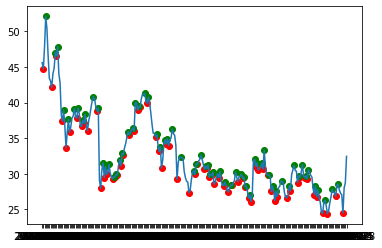

In [5]:
# Plot results
plt.scatter(maxr_df.Date, maxr_df['min'], c='r')
plt.scatter(maxr_df.Date, maxr_df['max'], c='g')
maxr_df.Close.plot()

In [6]:
# Find local peaks / values with noise reduction
n = 5
maxr_df['min_1'] = maxr_df.iloc[argrelextrema(maxr_df.Close.values, np.less_equal,
                    order=n)[0]]['Close']
maxr_df['max_1'] = maxr_df.iloc[argrelextrema(maxr_df.Close.values, np.greater_equal,
                    order=n)[0]]['Close']

<AxesSubplot:>

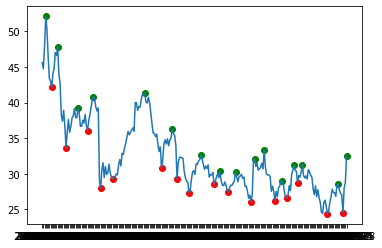

In [7]:
# Plot results
plt.scatter(maxr_df.Date, maxr_df['min_1'], c='r')
plt.scatter(maxr_df.Date, maxr_df['max_1'], c='g')
maxr_df.Close.plot()

In [8]:
maxr_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,min,max,min_1,max_1
0,2021-02-24,45.546429,45.599998,47.849998,44.740002,45.250000,1209100.0,NaN,NaN,NaN,NaN
1,2021-02-25,44.697426,44.750000,51.270000,44.250000,47.560001,2246700.0,44.75,NaN,NaN,NaN
2,2021-02-26,47.793785,47.849998,48.779999,44.070000,45.000000,1683400.0,NaN,NaN,NaN,NaN
3,2021-03-01,52.058769,52.119999,52.439999,48.250000,50.000000,1215600.0,NaN,52.119999,NaN,52.119999
4,2021-03-02,50.280865,50.340000,51.770000,50.150002,51.509998,745000.0,NaN,NaN,NaN,NaN


In [9]:
# isolate local max and mins with and without noise reduction
max_sr = [(row.Date, row.max_1) for row in maxr_df.itertuples() if row.max_1 > 0]
min_sr = [(row.Date, row.min_1) for row in maxr_df.itertuples() if row.min_1 > 0]
max_ = [(row.Date, row.max) for row in maxr_df.itertuples() if row.max > 0]
min_ = [(row.Date, row.min) for row in maxr_df.itertuples() if row.min > 0]

In [279]:
def levels(df, sensitivity=3, tests=3, noise_r=0.01):
    # Get list of all minimum and maximum levels
    max_sr = [(row.Date, row.max_1) for row in df.itertuples() if row.max_1 > 0]
    min_sr = [(row.Date, row.min_1) for row in df.itertuples() if row.min_1 > 0]
    sr = sorted([[mx for mx in max_sr]+[mn for mn in min_sr]][0])
    
    # Init dictionary to store level strength
    sr_dict = {}
    
    # itereate through rows to establish and test levels
    for row in df.itertuples():
        body = abs(row.Close - row.Open)
        wick = abs(row.High - row.Low)
        candle_ratio = body/wick
        for point in sr:
            price = point[1]
            date = point[0]
            if price in sr_dict and row.Date > date:

                    
                # Close bullish inside and wick above
                if (row.Close >= (price-sensitivity) and row.Close <= (price+sensitivity)) and candle_ratio > 0.5:
                    sr_dict[price] += 1

                    
            else:
                sr_dict[price] = 0
    
    # Filter dictionary to only store levels that have been tested
    sr_dict = dict(filter(lambda val: val[1] >= tests, sr_dict.items()))
    
    # Filters strength dictionary to only include levels above a strength level
    sr = sorted([level for level, strength in sr_dict.items() if strength >= tests])
    
    # Conduct noise reduction using noise_reduction parameter
    sr_df = pd.DataFrame(sr, columns=["lvl"])
    sr_df["lvl p"] = sr_df.pct_change()

    # Filter noise
    sr = [sr_df.iloc[row[0]]['lvl'] for row in sr_df.itertuples() if row[0] > 0 if abs(row[2]) > noise_r]
    
    # Filter dictionary with values from list
    sr_dict = {key:sr_dict[key] for key in sr if key in sr_dict.keys()}
    
    # Return the levels and their strengths as a list and dictionary
    return sr, sr_dict

In [280]:
sr, sr_dict = levels(maxr_df, sensitivity=0.5)

In [281]:
sr

[26.600000381469727,
 27.34000015258789,
 27.950000762939453,
 28.5,
 29.209999084472656,
 30.229999542236328,
 30.780000686645508,
 33.63999938964844,
 36.04999923706055]

In [282]:
sr_dict

{26.600000381469727: 3,
 27.34000015258789: 8,
 27.950000762939453: 12,
 28.5: 10,
 29.209999084472656: 11,
 30.229999542236328: 10,
 30.780000686645508: 12,
 33.63999938964844: 3,
 36.04999923706055: 3}

In [283]:
data = maxr_df.set_index(pd.to_datetime(maxr_df.Date))

In [284]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

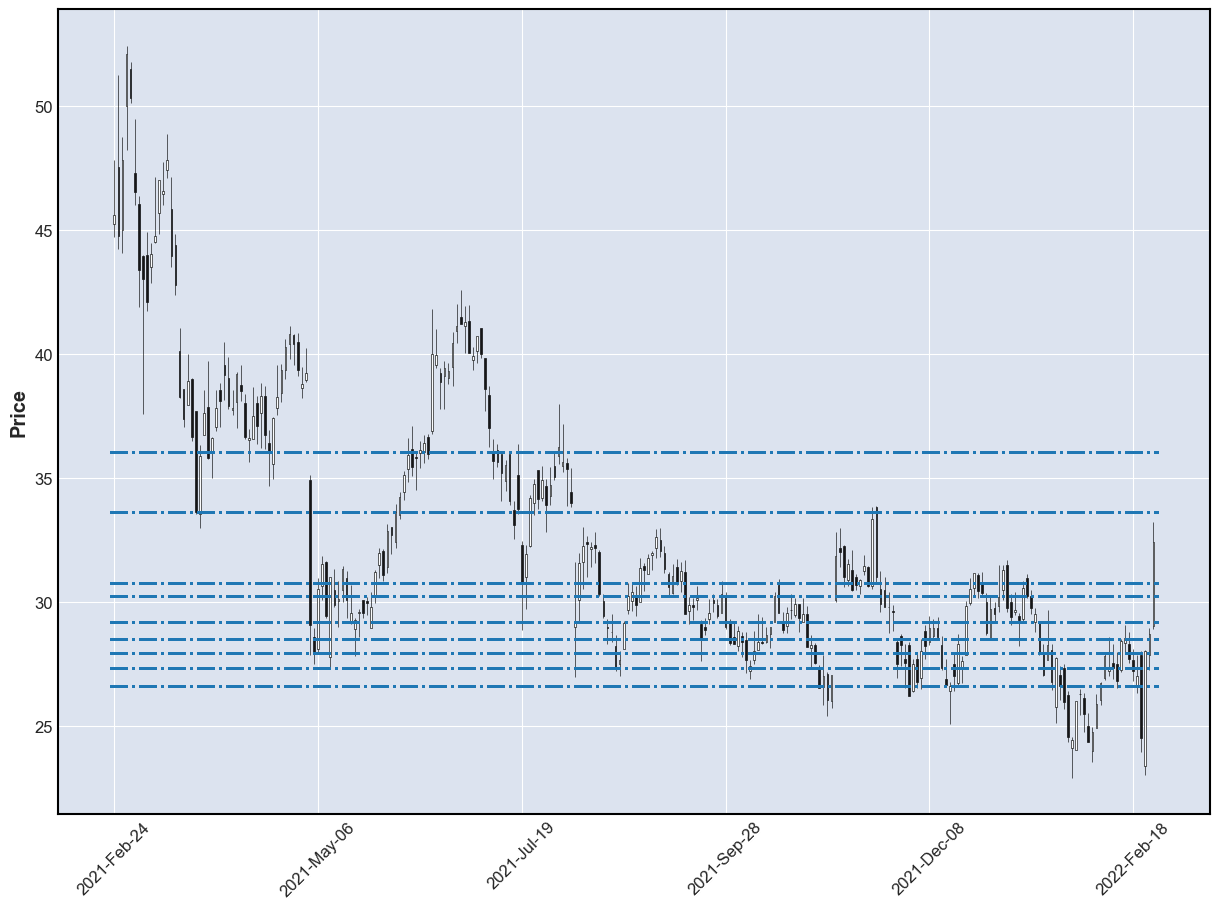

In [285]:
mpf.plot(data,hlines=dict(hlines=sr,linestyle='-.'),type='candle', figscale=2)

In [176]:
maxr_df.to_csv('maxr_df.csv')